# 泰坦尼克号幸存者预测

## 背景

1912年4月14日23点40分，泰坦尼克号与一座冰山相撞，2小时40分钟后沉没。共造成2224名船员及乘客中，710人生还，1514人丧生，存活率为32%。

**航行路线**：https://upload.wikimedia.org/wikipedia/commons/5/51/Titanic_voyage_map.png

**船舱布局**：https://upload.wikimedia.org/wikipedia/commons/8/84/Titanic_cutaway_diagram.png

**事故详情**：https://en.wikipedia.org/wiki/RMS_Titanic

**女士和儿童优先**：https://en.wikipedia.org/wiki/Women_and_children_first

**具体时间线参考**：https://www.historyonthenet.com/titanic-timeline-3/

**补充摘要**
- 4月15日0点45分，第一艘救生艇被放下。
- 4月15日2点05分，最后一艘救生艇被放下。
- 救生艇可容纳1178乘客, 465座位为空。
- 当时海水温度约0度，可存活时长为15分钟。
- 一等舱票价	£30
- 二等舱票价	£12
- 三等舱票价 £3–£8

**结论**

从上述信息我们可以大胆推测妇女儿童、社会地位高、靠近救生舱也就是上层甲板客舱的乘客的生还率较高，而由于家庭成员多拖慢了逃生速度，这些乘客的生还率应该较低。在接下来的分析中应重点关注这些信息。

### 目的
泰坦尼克号失事的乘客进行生还概率的预测分析。

### 数据来源
https://www.kaggle.com/c/titanic/data 

## 1.数据加载

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [2]:
train = pd.read_csv('.\data\train.csv')
test = pd.read_csv('.\data\test.csv')

In [3]:
combined = pd.concat([train, test], ignore_index = True)

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


特征字段：
- **PassengerId：** 乘客ID
- **Pclass：** 乘客等级(1/2/3等舱位)
- **Name：** 乘客姓名
- **Sex：** 性别
- **Age：** 年龄
- **SibSp：** 兄弟姐妹和配偶个数
- **Parch：** 父母与小孩个数
- **Ticket：** 船票信息
- **Fare：** 票价
- **Cabin：** 客舱
- **Embarked：** 登船港口

Target：
- **Survived: ** 是否生还（1表示生还，0表示遇难）

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


训练集共891条数据，含空值字段  
- Cabin 缺失687条

- Age 缺失177条

- Embarked  缺失2条

测试集418条，含空值字段  
- Cabin 缺失327条

- Age 缺失86条

- Fare  缺失1条

In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- 正负样本（获救为正样本）比约1:2 

- 2、3等舱的乘客要比1等舱多

- 乘客主要以青壮年为主

- 超过75%乘客没有与家属一同搭乘

- 票价差异较大



In [9]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",male,347082,G6,S
freq,1,577,7,4,644


- 65%为男性
- 存在共票和共船舱现象
- 共3个港口，S港口登船人数最多

## 2.特征分析

### 2.1.数值型变量

In [10]:
sns.set(style='white')
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

In [11]:
cols = ['#5d91a7', '#00516c', '#00a4dc', '#6bcff6','#008982','#6dbbbf','#7a250f','#ea8f74','#a8a9ad']
sns.set_palette(palette = cols, n_colors = 9)

### 变量之间相关性

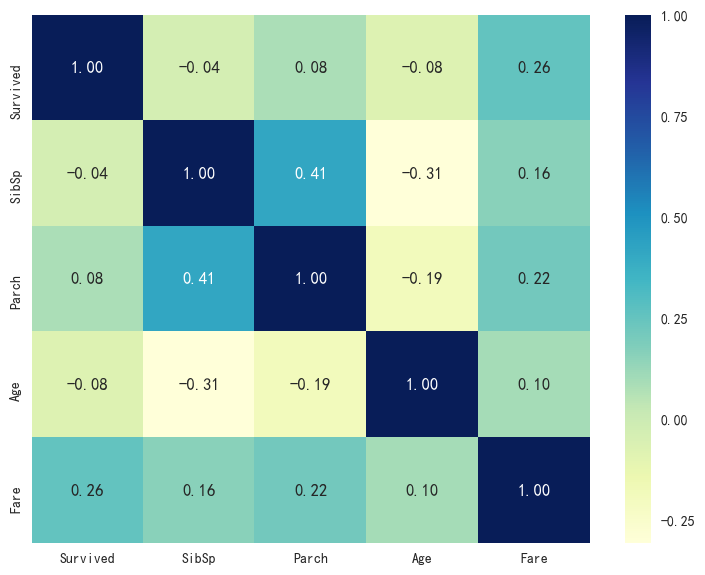

In [58]:
plt.figure(figsize=(9, 7),dpi=100)
sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True, fmt = '.2f',cmap='YlGnBu')
plt.show()

- 票价和生还率有较高的相关性
- Sibsp对Age缺失值的填充应该是不错的选择

### Age年龄

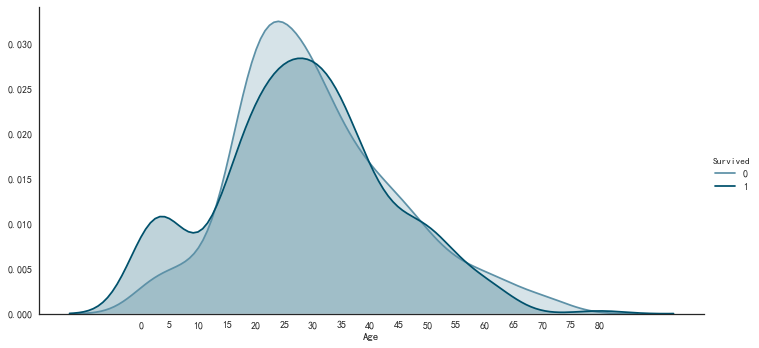

In [13]:
plt.figure(figsize=(9, 7),dpi=100)
g = sns.FacetGrid(train, hue='Survived',size=5,aspect=2)
g.map(sns.kdeplot,'Age',shade=True)
xtick = np.arange(0, 81,5)
plt.xticks(xtick)
g.add_legend()
plt.show()

- 从图中我们不难发现，年龄的分布近似为正态分布。
- 年龄在5岁左右出现一个幸存高峰，60-80岁的老年人的生存几率较低。 一般来说，年轻乘客比老年人有更大的生存机会。
- 从而，我们可以说有一些年龄段的乘客有更大或更差的生存机会。

因此，这可能是一个很好的特征，后续进行离散化处理。

### Fare票价

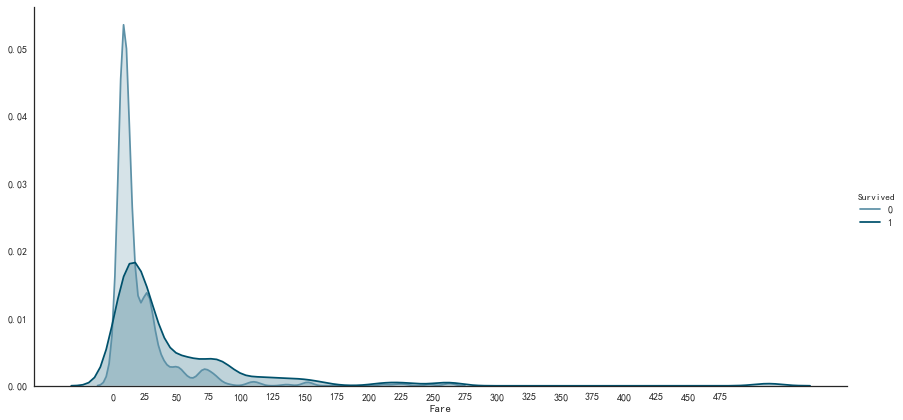

In [14]:
plt.figure(figsize=(9, 7),dpi=100)
g = sns.FacetGrid(train, hue='Survived',size=6,aspect=2)
g.map(sns.kdeplot,'Fare',shade= True)
xtick = np.arange(0, 500,25)
plt.xticks(xtick)
g.add_legend()
plt.show()

- 正如我们所看到的，票价分布呈现严重右偏态分布。
- 票价低的乘客生存机会较低，票价高的乘客有更高的生存机会。 

所以，后续进行对数变换降低偏态影响。

### Pclass座舱等级

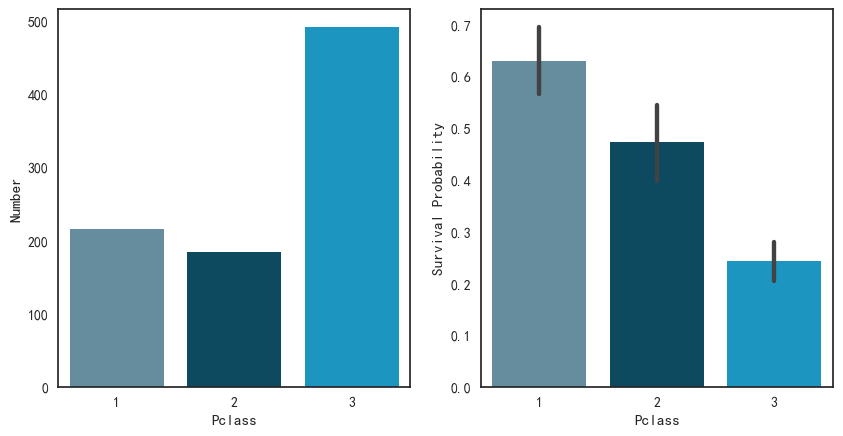

In [15]:
plt.figure(figsize=(10, 5),dpi=100)
plt.subplot(121)
sns.countplot(x='Pclass', data=train)
plt.ylabel('Number')
plt.subplot(122)
sns.barplot(x='Pclass', y='Survived', data=train)
plt.ylabel('Survival Probability')
plt.show()

- 我们可以看到，3等舱的乘客人数最多，随着座舱等级下降，生存的机会也随之下降。
- 一等舱有最好的生存机会 
 - 或许由于社会经济地位较高而被优先考虑，
 - 或者他们位于较高层甲板，有利于逃生。
- 相对的，三等舱的生存机会最低。

### Parch父母儿童数量

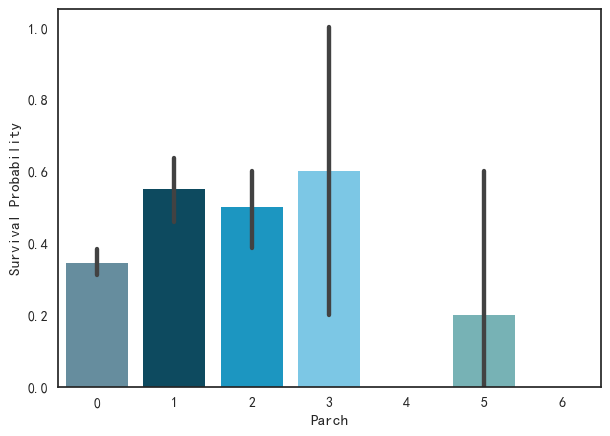

In [16]:
plt.figure(figsize=(7, 5),dpi=100)
sns.barplot(x='Parch', y='Survived', data=train)
plt.ylabel('Survival Probability')
plt.show()

- 在这里我们可以看到，家庭中父母和孩子的数量越少，乘客生存的可能性就越大。
 - 有可能是因为，比如老人孩子拖慢了逃生速度。

### SibSp兄弟姐妹配偶数量

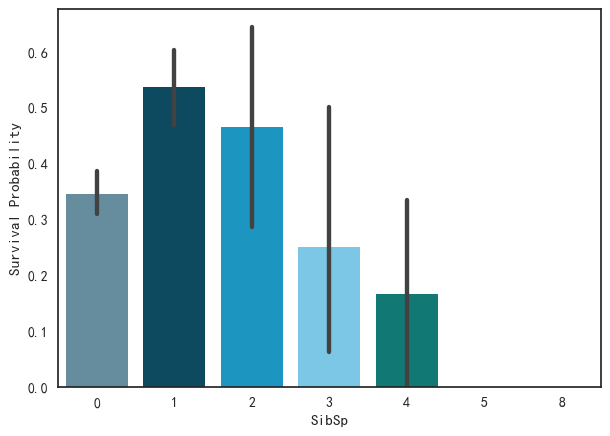

In [17]:
plt.figure(figsize=(7, 5),dpi=100)
sns.barplot(x='SibSp', y='Survived', data=train)
plt.ylabel('Survival Probability')
plt.show()

- 看起来乘客上有许多兄弟姐妹或配偶的乘客生存的可能性较低。

可以和“Parch”创建一个家庭规模新变量。

### 2.2 类别型变量

### Sex性别

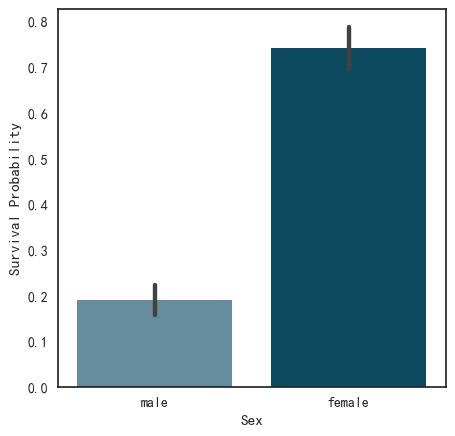

In [18]:
plt.figure(figsize=(5, 5),dpi=100)
sns.barplot(x='Sex', y='Survived', data=train)
plt.ylabel('Survival Probability')
plt.show()

- 不出所料，女性乘客的生存几率远高于男性乘客。

所以，对于生存预测来说性别应该是一个极为重要的特征。

### Embarked港口与生还关系

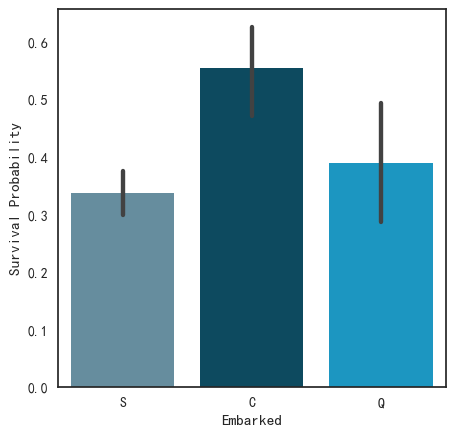

In [19]:
plt.figure(figsize=(5, 5),dpi=100)
sns.barplot(x='Embarked', y='Survived', data=train)
plt.ylabel('Survival Probability')
plt.show()

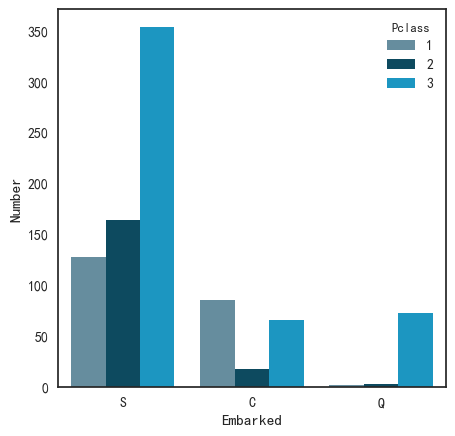

In [20]:
plt.figure(figsize=(5, 5),dpi=100)
sns.countplot(x='Embarked',hue='Pclass',data=train)
plt.ylabel('Number')
plt.show()

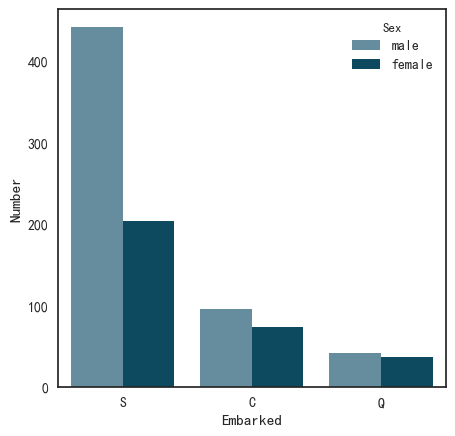

In [21]:
plt.figure(figsize=(5, 5),dpi=100)
sns.countplot(x='Embarked',hue='Sex',data=train)
plt.ylabel('Number')
plt.show()

- 从图中我们可以看到，瑟堡港口乘客生还几率高于其它港口
 - 或许是各个港口乘客的类型差异所导致，从性别和座舱的分布也能佐证这点。


### Cabin客舱

In [22]:
train['Cabin'] = train['Cabin'].fillna('Unknown')
train['Deck']= train['Cabin'].str.get(0)

In [23]:
#train['Cabin'].unique()

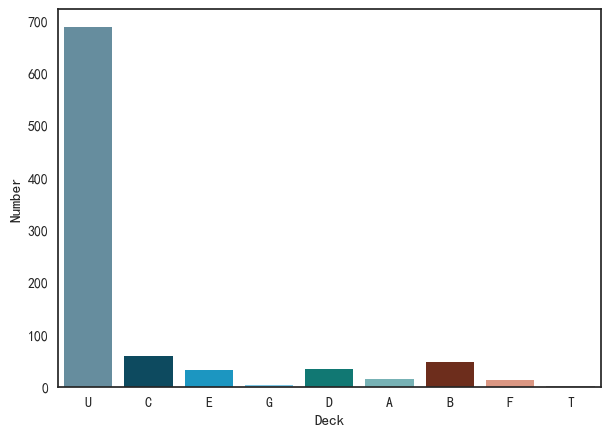

In [24]:
plt.figure(figsize=(7, 5),dpi=100)
sns.countplot(x='Deck', data=train)
plt.ylabel('Number')
plt.show()

- 从图上我们看到可以看到大多数乘客cabin信息丢失，而从甲板船舱分布以及各等级乘客数量分布来看，可以推测缺失的cabin值乘客主要集中在低层甲板

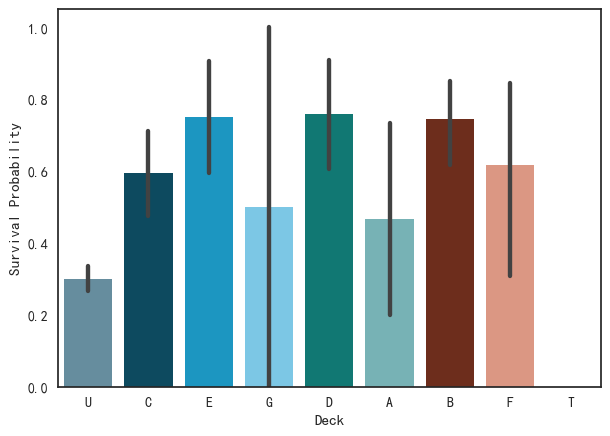

In [25]:
plt.figure(figsize=(7, 5),dpi=100)
sns.barplot(x='Deck', y='Survived', data=train)
plt.ylabel('Survival Probability')
plt.show()

- 从图上我们可以发现cabin信息缺失的乘客生存率几率偏高

可以将缺失值单独归为一类

## 3.特征工程

### Title(new)

- 利用Name构建新变量Title

In [26]:
titles = set()
for name in combined['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())
#titles

In [27]:
combined['Title'] = combined['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady','Jonkheer'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master'], 'Master'))
combined['Title'] = combined['Title'].map(Title_Dict)

In [28]:
combined.groupby(['Title'], as_index=False)['Survived'].mean().sort_values(by='Survived', ascending=False)

,Title,Survived
3,Mrs,0.795276
1,Miss,0.701087
5,Royalty,0.600000
0,Master,0.575000
4,Officer,0.277778
2,Mr,0.156673


- 虚拟编码

In [29]:
titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
combined = pd.concat([combined, titles_dummies], axis=1)
combined.drop(['Name','Title'], axis=1, inplace=True)

### Sex

- 虚拟编码

In [30]:
sex_dummies = pd.get_dummies(combined['Sex'], prefix='Sex')
combined = pd.concat([combined, sex_dummies], axis=1)
combined.drop('Sex', axis=1, inplace=True)

### Fare

- 缺失值填充/异常值处理

In [31]:
combined.Fare = combined.Fare.map(lambda x: np.nan if x==0 else x)

In [32]:
def setfare(x):
    faregroup = combined.iloc[:891][['Fare', 'Pclass']].groupby('Pclass').median()
    if pd.isnull(x['Fare']) :
        x['Fare'] = float(faregroup.loc[x['Pclass']])
    return x

In [33]:
combined = combined.apply(lambda x: setfare(x), axis=1 )

- 对数变换

In [34]:
combined['Fare'] = combined['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

### Pclass

- 虚拟编码

In [35]:
pclass_dummies = pd.get_dummies(combined['Pclass'], prefix='Pclass')
combined = pd.concat([combined, pclass_dummies], axis=1)
combined.drop('Pclass', axis=1, inplace=True)

### Age

- 缺失值填充

In [36]:
age_df = combined.filter(regex='Age|Pclass|SibSp|Title')
age_train = age_df.iloc[:891]
known_age = age_train[age_train.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rf = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
rf.fit(X, y)
predictedAges = rf.predict(unknown_age[:, 1:])
combined.loc[ (combined.Age.isnull()), 'Age' ] = predictedAges

- 分组离散化

In [37]:
bins = [ 0, 6, 60, np.inf]
labels = ['Baby','Adult','Senior']
combined['AgeGroup'] = pd.cut(combined['Age'], bins,labels=labels,right=False)
combined.groupby(['AgeGroup'], as_index=False)['Survived'].mean().sort_values(by='Survived', ascending=False)

,AgeGroup,Survived
0,Baby,0.660000
1,Adult,0.370552
2,Senior,0.269231


- 虚拟编码

In [38]:
AgeGroup_dummies = pd.get_dummies(combined['AgeGroup'], prefix='AgeGroup')
combined = pd.concat([combined, AgeGroup_dummies], axis=1)
combined.drop(['Age','AgeGroup'], axis=1, inplace=True)

### Embarked

- 缺失值填充

In [39]:
freq_port = combined.iloc[:891].Embarked.mode()[0]
combined['Embarked'] = combined['Embarked'].fillna(freq_port)

- 虚拟编码

In [40]:
embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
combined = pd.concat([combined, embarked_dummies], axis=1)
combined.drop('Embarked', axis=1, inplace=True)

### FamilySize(new)

- 利用SibSp/Parch构建新变量

In [41]:
combined['FamilySize'] = combined['SibSp'] + combined['Parch']

In [42]:
combined.groupby(['FamilySize'])['Survived'].mean().sort_values( ascending=False)

FamilySize
3     0.724138
2     0.578431
1     0.552795
6     0.333333
0     0.303538
4     0.200000
5     0.136364
10    0.000000
7     0.000000
Name: Survived, dtype: float64

- 分组离散化

In [43]:
combined['Single'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)

In [44]:
combined.drop(['SibSp','Parch','FamilySize'],axis=1,inplace=True)

### Deck(new)

- 缺失值填充

In [45]:
combined['Cabin'] = combined['Cabin'].fillna('Unknown')

- 利用Cabin构建新变量Deck

In [46]:
combined['Deck']=combined['Cabin'].str.get(0)

- 虚拟编码

In [47]:
deck_dummies = pd.get_dummies(combined['Deck'], prefix='Deck')
combined = pd.concat([combined,deck_dummies], axis=1)
combined.drop(['Cabin','Deck'], axis=1, inplace=True)

### TktPre(new)

- 利用Ticket构建新变量TktPre

In [48]:
TktPre = []
for i in list(combined.Ticket):
    if not i.isdigit() :
        TktPre.append(i.replace('.','').replace('/','').strip()[0])
    else:
        TktPre.append('X')
        
combined['TktPre'] = TktPre

- 虚拟编码

In [49]:
tktPre_dummies = pd.get_dummies(combined['TktPre'], prefix='TktPre')
combined = pd.concat([combined, tktPre_dummies], axis=1)
combined.drop(['Ticket','TktPre'], inplace=True, axis=1)

### 选取特征

In [50]:
combined.drop(['PassengerId','Survived'], axis=1, inplace=True)

In [51]:
X_train = combined.iloc[:891]
Y_train = train['Survived']
X_test = combined.iloc[891:]

## 4.建模

### 参数优化选择

In [52]:
rf = RandomForestClassifier(max_features='sqrt',random_state=42)
parameter_grid = {
                 'max_depth' : [6,7,8],
                 'n_estimators': [20,50]
                 }
grid_search = GridSearchCV(rf,
                           param_grid=parameter_grid,
                           cv=5)
grid_search.fit(X_train, Y_train)
print(grid_search.grid_scores_)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

[mean: 0.82043, std: 0.02554, params: {'max_depth': 6, 'n_estimators': 20}, mean: 0.81706, std: 0.01276, params: {'max_depth': 6, 'n_estimators': 50}, mean: 0.81818, std: 0.01696, params: {'max_depth': 7, 'n_estimators': 20}, mean: 0.82379, std: 0.02067, params: {'max_depth': 7, 'n_estimators': 50}, mean: 0.81930, std: 0.02351, params: {'max_depth': 8, 'n_estimators': 20}, mean: 0.81818, std: 0.02251, params: {'max_depth': 8, 'n_estimators': 50}]
Best score: 0.8237934904601572
Best parameters: {'max_depth': 7, 'n_estimators': 50}


C:\Users\Weizh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [53]:
parameters = {'max_depth': 7, 'n_estimators': 50}

In [54]:
X_train.columns

Index(['Fare', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'AgeGroup_Baby', 'AgeGroup_Adult',
       'AgeGroup_Senior', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Single',
       'SmallFamily', 'LargeFamily', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U', 'TktPre_A',
       'TktPre_C', 'TktPre_F', 'TktPre_L', 'TktPre_P', 'TktPre_S', 'TktPre_W',
       'TktPre_X'],
      dtype='object')

### 学习曲线

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes, verbose=verbose)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    plt.figure(figsize=(7,5),dpi=100)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='g', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='r', label='Cross-validation Score')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                    alpha=0.1, color='g')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                    alpha=0.1, color='r')

    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    return plt


C:\Users\Weizh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Weizh\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


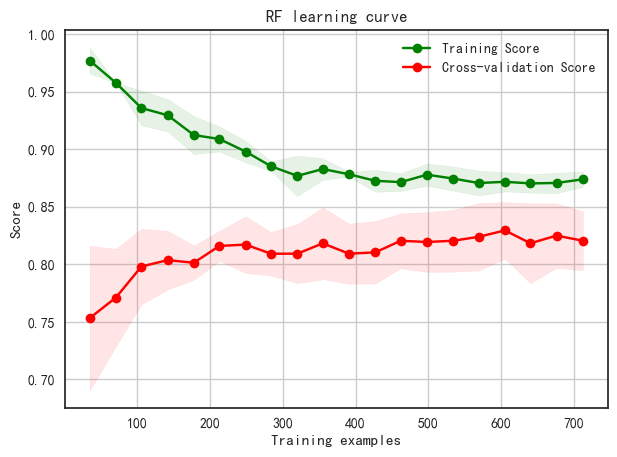

In [56]:
rf = RandomForestClassifier(max_features='sqrt',random_state=42,class_weight={0:0.6,1:0.4},**parameters)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
plot_learning_curve(rf, 'RF learning curve', X_train, Y_train,cv=5)
plt.show()

- 从图上来看，模型效果还算符合预期，不过似乎出现了高方差问题，后续可以进行特征筛选去解决这个问题。

### 结果预测

In [57]:
submission = pd.DataFrame({
        'PassengerId': test['PassengerId'],
        'Survived': Y_pred
    })
submission.to_csv('submission.csv', index=False)

## 5.总结

本项目完成了对 Taitanic 幸存者的预测和分析，Kaggle最终预测准确率为 `0.80861`，准确率还有很大的提升空间，后续可以从下面几方面完善模型：
- 深入挖掘属性间关系，构建更多有效特征；
- 特征筛选，删去冗余特征；
- 参数调整；
- 尝试新的模型，比如xgboost；
- 尝试模型融合（stacking）。

